In [1]:
import sqlite3
import pandas as pd
import numpy as np

from sentence_transformers import SentenceTransformer
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score, calinski_harabasz_score
from sklearn.preprocessing import normalize
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import DBSCAN
from umap.umap_ import UMAP
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
import numpy as np
import hdbscan

from statistics import mode
import os
from dotenv import load_dotenv

load_dotenv()
DB_PATH = os.getenv("DATABASE_URL", "sqlite.db")

import logging

logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")

/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# The model

In [2]:
#embedder_model = 'sentence-transformers/paraphrase-multilingual-MiniLM-L12-v2'
embedder_model='sentence-transformers/paraphrase-multilingual-mpnet-base-v2'
#embedder_model="hiiamsid/sentence_similarity_spanish_es"
embedder = SentenceTransformer(embedder_model)

2025-05-02 00:46:20,200 - INFO - Use pytorch device_name: mps
2025-05-02 00:46:20,200 - INFO - Load pretrained SentenceTransformer: sentence-transformers/paraphrase-multilingual-mpnet-base-v2


# Some functions

In [37]:

def optimalK(data, nrefs=3, maxClusters=15):
    """
        Gap Statistic for K means
    """
    gaps = np.zeros((len(range(1, maxClusters)),))
    resultsdf = []

    for gap_index, k in enumerate(range(1, maxClusters)):
        # Holder for reference dispersion results
        refDisps = np.zeros(nrefs)# For n references, generate random sample and perform kmeans getting resulting dispersion of each loop

        for i in range(nrefs):
            # Create new random reference set
            randomReference = np.random.random_sample(size=data.shape)

            # Fit to it
            km = KMeans(k)
            km.fit(randomReference)

            refDisp = km.inertia_
            refDisps[i] = refDisp

            # Fit cluster to original data and create dispersion
            km = KMeans(k)
            km.fit(data)

            origDisp = km.inertia_# Calculate gap statistic
            gap = np.log(np.mean(refDisps)) - np.log(origDisp)# Assign this loop's gap statistic to gaps
            gaps[gap_index] = gap

            resultsdf.append([k,gap])

            df_extended = pd.DataFrame(resultsdf, columns=['clusterCount', 'gap'])

    return (gaps.argmax() + 1, df_extended)


def fetch_questions(table_name, rei_id, period):
    query = f"""
        SELECT question, coalesce(g.id, 'Desconocido') as group_id, coalesce(u.name, 'Desconocido') as lider_name
        FROM {table_name} q
        LEFT JOIN "class" c ON c.id = q.class_id
        LEFT JOIN "group" g ON g.id = q.group_id
        LEFT JOIN "user" u ON u.id = g.lider_id
        WHERE c.id = ? AND c.recorrido_id = ?;
    """

    with sqlite3.connect(DB_PATH) as con:
        cursor = con.cursor()
        cursor.execute(query, (period, rei_id))
        result = cursor.fetchall()
        logging.debug(f"Fetched {len(result)} questions from {table_name} for REI ID: {rei_id} and period: {period}")
        return result


def preprocess_questions(questions):
    if not questions:
        return pd.DataFrame(columns=["pregunta", "grupo", "lider_name", "votos"])

    dfcorpus = pd.DataFrame(questions)
    dfcorpus = dfcorpus.rename(columns={0: "pregunta", 1: "grupo", 2: "lider_name"})

    dfcorpus["votos"] = 1
    corpus = dfcorpus["pregunta"].tolist()
    corpus_embeddings = embedder.encode(corpus)

    # Compute cosine similarities
    similarities = embedder.similarity(corpus_embeddings, corpus_embeddings)
    to_remove = []

    for idx_i, sentence1 in enumerate(corpus):
        count_matches = 0
        match_groups = dfcorpus['grupo'].iloc[idx_i]

        for idx_j, sentence2 in enumerate(corpus):
            sim = similarities[idx_i][idx_j]

            if (sim > 0.9) and (idx_i != idx_j):
                count_matches += 1
                gxj = dfcorpus['grupo'].iloc[idx_j]
                match_groups = match_groups + "," + gxj

                if (idx_j>idx_i):
                    to_remove.append(idx_j)

        dfcorpus.iloc[idx_i, dfcorpus.columns.get_loc('votos')] = count_matches + 1
        dfcorpus.iloc[idx_i, dfcorpus.columns.get_loc('grupo')] = str(match_groups)

    if len(to_remove)>0:
        rm_indexes = np.array(to_remove)
        dfcorpus = dfcorpus.drop(dfcorpus.index[rm_indexes])

    return dfcorpus

@staticmethod
def select_optimal_k(embeddings, maxClusters=15):
    """
        Selecciona el número óptimo de clusters utilizando el método del codo y la puntuación de Silhouette.
    """
    best_k = 2
    best_score = -1
    for k in range(2, maxClusters + 1):
        kmeans = KMeans(n_clusters=k, random_state=42).fit(embeddings)
        score = silhouette_score(embeddings, kmeans.labels_, metric='cosine')
        if score > best_score:
            best_k = k
            best_score = score
    if best_k == 1:
        logging.warning("El número óptimo de clusters es 1. Esto puede indicar que los datos no tienen suficiente variación.")
    logging.info(f"Optimal k: {best_k} (Silhouette Score: {best_score:.3f})")
    return max(best_k, 2)  # Asegurarse de que k sea al menos 2

def merge_similar_clusters(df, embeddings, threshold=0.85):
    # Calcular centroides de cada cluster
    centroids = []
    clusters = df['cluster'].unique()
    for cluster in clusters:
        cluster_embeddings = embeddings[df['cluster'] == cluster]
        centroids.append(np.mean(cluster_embeddings, axis=0))
    
    # Matriz de similitud entre centroides
    sim_matrix = cosine_similarity(centroids)
    
    # Fusionar clusters similares
    clusters_merged = {}
    new_cluster_id = 0
    for i, cluster in enumerate(clusters):
        if cluster not in clusters_merged:
            clusters_merged[cluster] = new_cluster_id
            for j in range(i + 1, len(clusters)):
                if sim_matrix[i][j] > threshold:
                    clusters_merged[clusters[j]] = new_cluster_id
            new_cluster_id += 1
    
    # Aplicar fusión al DataFrame
    df['cluster'] = df['cluster'].map(clusters_merged)
    return df

def plot_clusters(embeddings, cluster_assignment):
    reducer = UMAP(n_components=2, metric='cosine', random_state=42)
    reduced_embeds = reducer.fit_transform(embeddings)
    
    plt.scatter(reduced_embeds[:, 0], reduced_embeds[:, 1], 
                c=cluster_assignment, cmap='Spectral', s=10)
    plt.title("Clusters después de UMAP")
    plt.colorbar()
    plt.show()

# Kmeans y DBSCAN

In [61]:
def train_cluster_model(corpus_embeddings, num_clusters=None, k_method="gap"):
    if not num_clusters:
        if len(corpus_embeddings)<15:
            maxC=len(corpus_embeddings)
        else:
            maxC=16

        scores = []
        for i in range(0,5):
            if k_method == "elbow":
                score_g = select_optimal_k(corpus_embeddings, maxClusters=maxC)
            elif k_method == "gap":
                score_g, _ = optimalK(corpus_embeddings, nrefs=3, maxClusters=maxC)
            else:
                raise ValueError("Método de selección de k no válido. Use 'elbow' o 'gap'.")
            scores.append(score_g)

        score_g = mode(scores)
        num_clusters = score_g

    clustering_model = KMeans(n_clusters=num_clusters, random_state=42)
    clustering_model.fit(corpus_embeddings)

    return clustering_model


def clusterize_dx_questions(rei_id, period, n_components=15, num_clusters=None):
    questions = fetch_questions("dx_question", rei_id, period)
    dfcorpus = preprocess_questions(questions)
    
    if dfcorpus.empty:
        dfcorpus['cluster'] = None
        return dfcorpus

    corpus = dfcorpus["pregunta"].tolist()
    corpus_embeddings = embedder.encode(corpus)

    # Normalización de los embeddings
    scaler = StandardScaler()
    normalized_embeddings = scaler.fit_transform(corpus_embeddings)

    # Reducir dimensionalidad
    #pca = PCA(n_components=80, random_state=42)
    #reduced_embeddings = pca.fit_transform(normalized_embeddings)
    reducer = UMAP(n_components=n_components, random_state=42, n_neighbors=10, min_dist=0.3)  # min_dist bajo para mayor separación
    reduced_embeddings = reducer.fit_transform(normalized_embeddings)

    # Aplicar normalización
    embeddings_to_use = normalize(reduced_embeddings, norm='l2')

    # Entrenar el modelo de clustering
    clustering_model = train_cluster_model(embeddings_to_use, num_clusters)

    cluster_assignment = clustering_model.labels_
    cluster_assignment = [x + 1 for x in cluster_assignment]

    # 2. Post-procesamiento
    dfcorpus['cluster'] = cluster_assignment
    #dfcorpus = merge_similar_clusters(dfcorpus, embeddings_to_use, threshold=0.9)

    # 3. Visualización (opcional)
    plot_clusters(embeddings_to_use, dfcorpus['cluster'])

    # 4. Evaluación
    if len(set(cluster_assignment)) > 1:
        silhouette = silhouette_score(embeddings_to_use, cluster_assignment, metric='cosine')
        logging.info(f"Silhouette Score: {silhouette:.3f}")
    else:
        logging.warning("No se puede calcular el Silhouette Score con un único cluster.")

    
    return dfcorpus

In [5]:
rei_id = 'a40e039f-c630-4d30-a4db-e812e3106568'
period = 'cdbb4989-6aa7-4663-8dcf-5cee59a6f54a'

Batches:   0%|          | 0/3 [00:00<?, ?it/s]

Batches: 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/thesportydar/local_dev/reis-app/src/lib/report/.venv/lib/python3.13/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


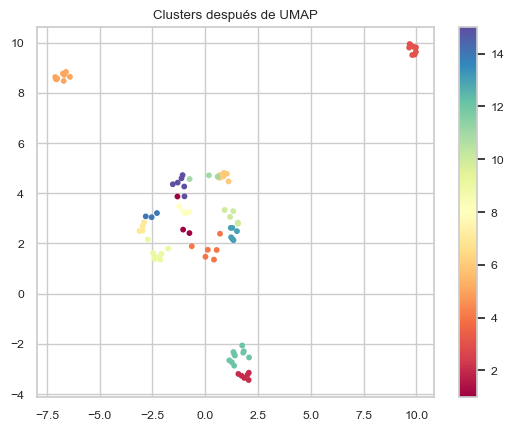

2025-05-02 01:27:56,086 - INFO - Silhouette Score: 0.569


In [62]:
df_info_reis_pregs = clusterize_dx_questions(rei_id, period, n_components=50, num_clusters=0)

# Comparar con el ground truth

In [7]:
df_real = pd.read_excel('./ZBE-es.xlsx')
# Limpiar nombres de columnas
df_real.columns = df_real.columns.str.strip().str.replace(r"\s+", " ", regex=True)
# Eliminar espacios al principio y al final de las celdas de texto
df_real = df_real.map(lambda x: x.strip() if isinstance(x, str) else x)
df_real = df_real.dropna(axis=1, how='any')

In [8]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

def purity_score(y_true, y_pred):
    contingency_matrix = metrics.cluster.contingency_matrix(y_true, y_pred)
    return np.sum(np.amax(contingency_matrix, axis=0)) / np.sum(contingency_matrix)

cols = ['JB', 'LF', 'KM1', 'NR1', 'MB']

In [63]:
labels_pred = df_info_reis_pregs[df_info_reis_pregs['cluster'] != -1]['cluster']
df = df_real.loc[labels_pred.index]

# verificamos que las preguntas sean las mismas
comparison = df['Question'] == df_info_reis_pregs.loc[labels_pred.index]['pregunta']
print(f"Total iguales: {comparison.sum()} / {len(comparison)}")

Total iguales: 87 / 87


In [64]:
resultados = []
for col in cols:
    labels_true = df[col]
    
    # Métricas
    ari = metrics.adjusted_rand_score(labels_true, labels_pred)
    nmi = metrics.normalized_mutual_info_score(labels_true, labels_pred)
    purity = purity_score(labels_true, labels_pred)  # Usar la función definida anteriormente
    hom = metrics.homogeneity_score(labels_true, labels_pred)
    com = metrics.completeness_score(labels_true, labels_pred)
    vm = metrics.v_measure_score(labels_true, labels_pred)

    
    resultados.append({
        'Categorización': col,
        'Adjusted Rand Index (ARI)': ari,
        'Normalized Mutual Info (NMI)': nmi,
        'Pureza': purity,
        'Homogeneity': hom,
        'Completeness': com,
        'V-measure': vm
    })

# Crear DataFrame de resultados
df_resultados = pd.DataFrame(resultados)
print(df_resultados)

  Categorización  Adjusted Rand Index (ARI)  Normalized Mutual Info (NMI)  \
0             JB                   0.326308                      0.627868   
1             LF                   0.060363                      0.473612   
2            KM1                   0.102295                      0.447999   
3            NR1                   0.180595                      0.521094   
4             MB                   0.163162                      0.476628   

     Pureza  Homogeneity  Completeness  V-measure  
0  0.735632     0.715565      0.559320   0.627868  
1  0.505747     0.510632      0.441597   0.473612  
2  0.563218     0.518837      0.394180   0.447999  
3  0.620690     0.596114      0.462846   0.521094  
4  0.632184     0.594211      0.397893   0.476628  


# Imprimir heatmaps

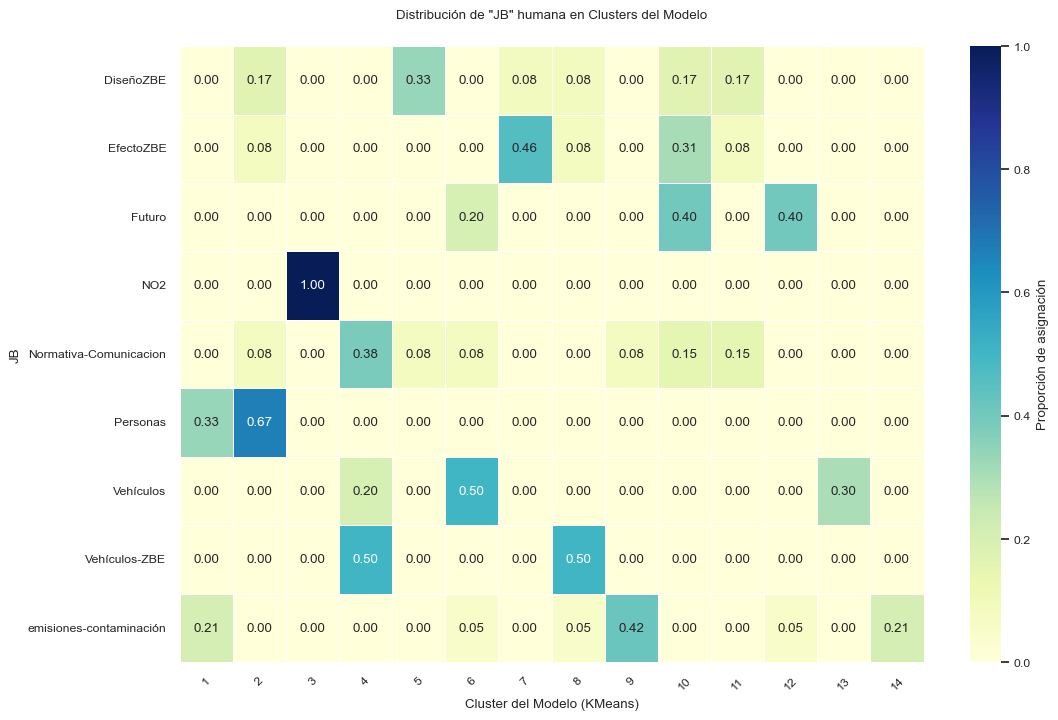

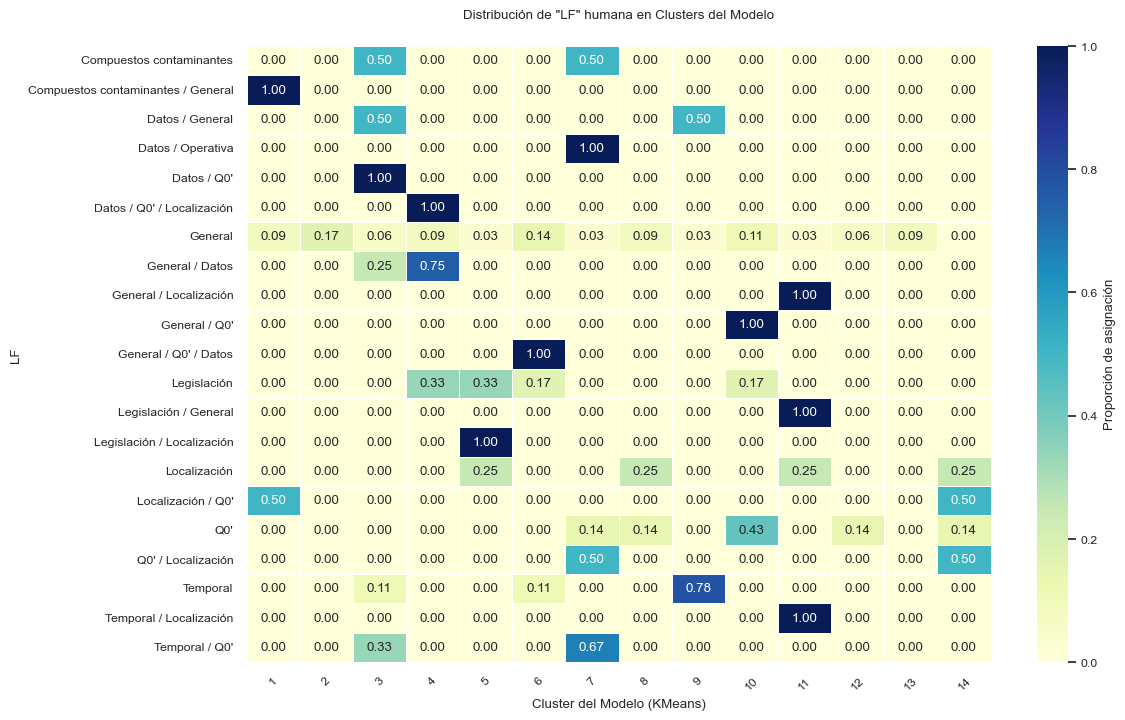

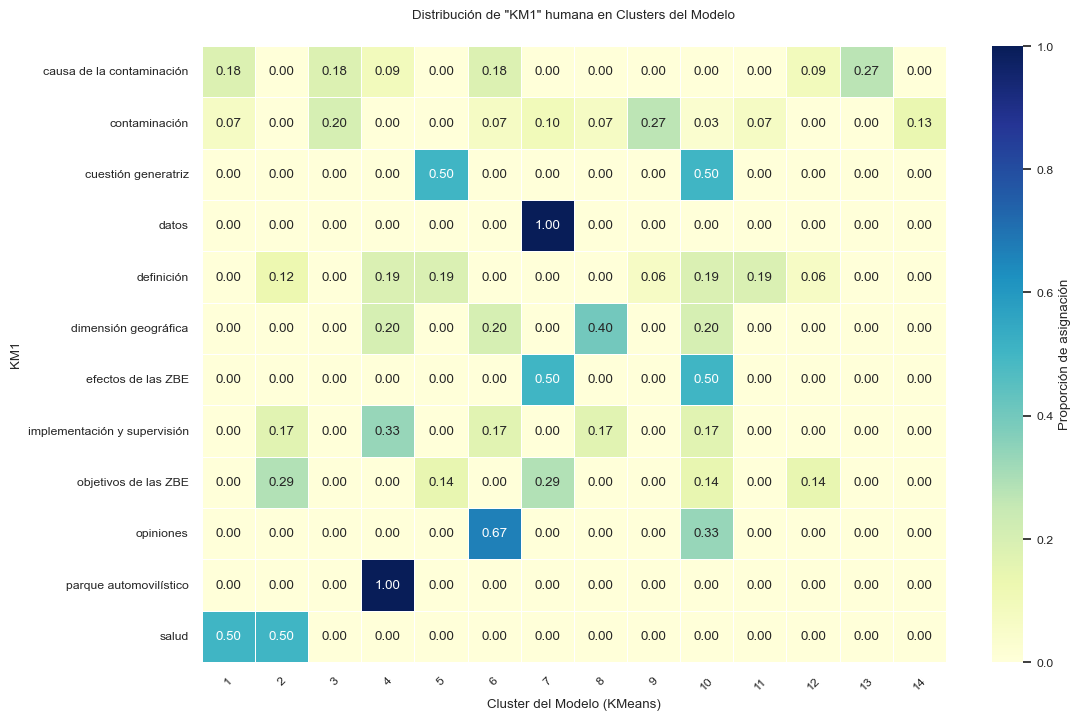

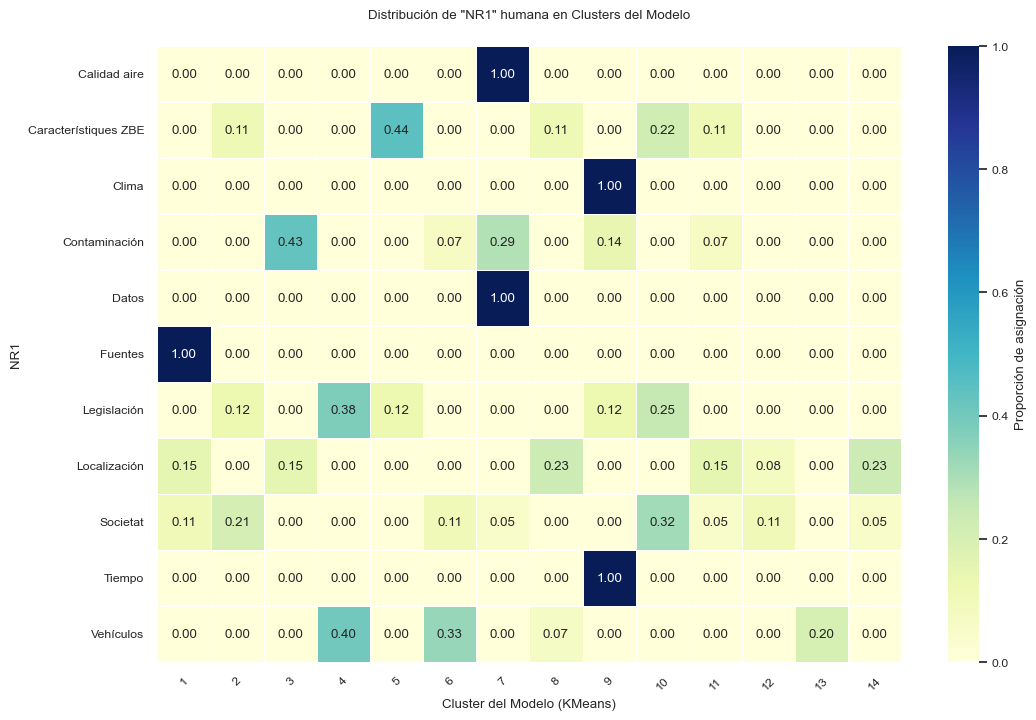

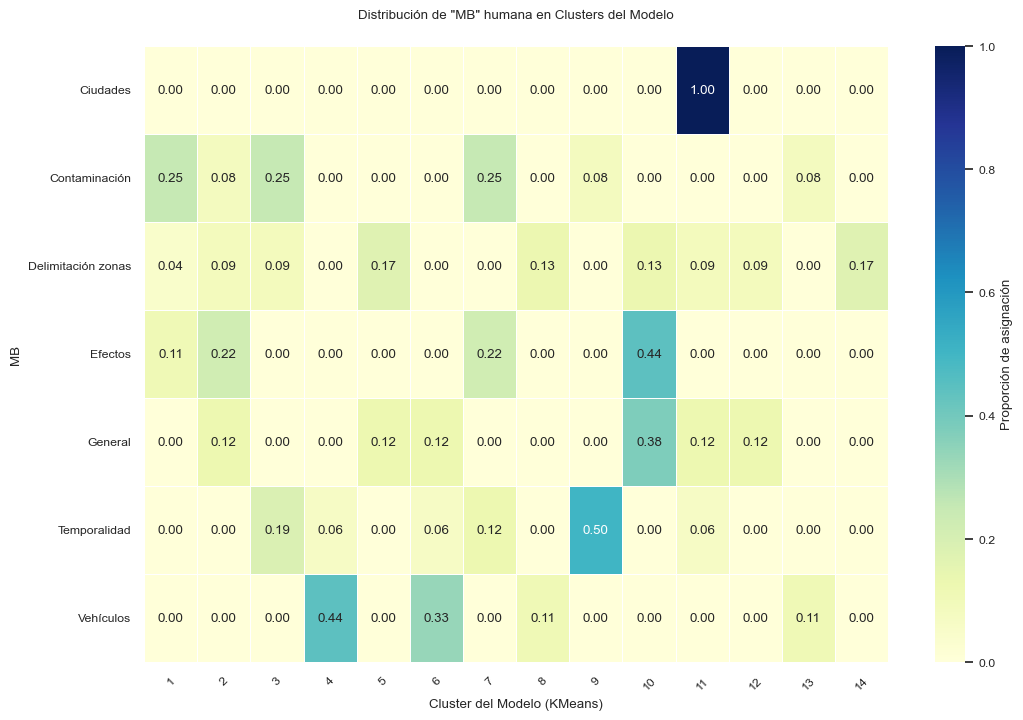

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Configurar estilo de los gráficos
sns.set(style="whitegrid", font_scale=0.8)

# Crear un heatmap por cada categorización humana
for col in cols:
    # Matriz de contingencia: frecuencias cruzadas entre categorías humanas y clusters del modelo
    contingency_matrix = pd.crosstab(df[col], labels_pred, normalize='index')
    
    # Configurar el tamaño del heatmap
    plt.figure(figsize=(12, 8))
    
    # Heatmap con anotaciones
    ax = sns.heatmap(
        contingency_matrix, 
        annot=True, 
        fmt=".2f",  # 2 decimales
        cmap="YlGnBu",  # Mapa de colores
        linewidths=0.5,
        cbar_kws={'label': 'Proporción de asignación'}
    )
    
    # Ajustes de título y ejes
    plt.title(f'Distribución de "{col}" humana en Clusters del Modelo', pad=20)
    plt.xlabel('Cluster del Modelo (KMeans)')
    plt.ylabel(col)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    
    # Mostrar el gráfico
    plt.show()